In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

pdf = pd.read_csv('./starkey_new.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


In [2]:
%%time

stats = Statistics.generate_kinematic_stats(starkey)

CPU times: user 31.7 s, sys: 1.11 s, total: 32.9 s
Wall time: 34.7 s


In [3]:
pivoted_stats = Statistics.pivot_stats_df(dataframe=stats,
                                          target_col_name='Species')
pivoted_stats

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.000000,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.000000,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.000000,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
930304E16,42.384012,67.090258,153.068542,341.254645,690.640774,0.000000,5864.020183,291.351804,396.220730,1156.455188,...,-0.068092,-0.026542,2.094546e-07,0.027375,0.066328,-7.865121,30.406105,0.001768,0.600187,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.000000,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384783,98.213522,275.921086,509.415791,1734.539050,0.000000,4968.850596,552.252200,797.302786,2019.896767,...,-0.013195,-0.006290,-1.456657e-04,0.006863,0.019363,-0.180602,0.032870,-0.001012,0.022347,2
OSUX92008,60.044073,113.846901,323.971240,582.606358,1036.441333,0.000000,3252.044721,469.226709,565.038959,2330.556507,...,-0.033016,-0.006065,4.739615e-05,0.008182,0.023711,-0.119311,0.119162,-0.001884,0.033022,2
OSUX91143,90.066320,141.983451,323.214222,635.102619,1447.090670,42.384352,6230.843732,652.128273,1043.556535,2741.029578,...,-0.011116,-0.002726,8.818090e-05,0.004994,0.011873,-0.029209,0.034114,0.000903,0.011857,2


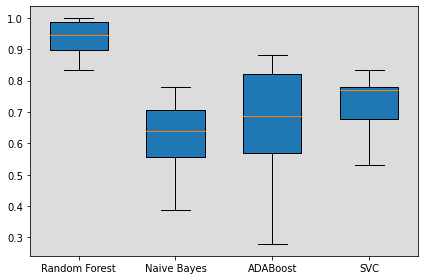

In [74]:
from sklearn.model_selection import cross_val_score
# Visualization tools.
import matplotlib.pyplot as plt
import seaborn as sns

# Models.
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Metric calculation.
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold



# Split the test and train dataset.
# train_x, test_x, train_y, test_y = train_test_split(pivoted_stats.drop(columns=['Species']),
#                                                     pivoted_stats["Species"], test_size=0.15)
# Declare all the models that we are going to train.
names = ["Random Forest", "Naive Bayes", "ADABoost", "SVC"]
models = [RandomForestClassifier(), GaussianNB(),
          AdaBoostClassifier(), SVC()]

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species').to_numpy()
Y = pivoted_stats['Species'].to_numpy()

# Separate out 30% of the data for the final testing.
train_vals, final_test, \
train_ans, final_test_ans = train_test_split(X, Y, test_size=0.3)


ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
# For each model defined above, predict the species for
# our animals.
for i, name, model in zip(range(0, 4), names, models):
    fit = model.fit(train_vals, train_ans)
    scores = cross_val_score(model, train_vals, train_ans,
                             scoring='accuracy', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True, widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
plt.tight_layout()

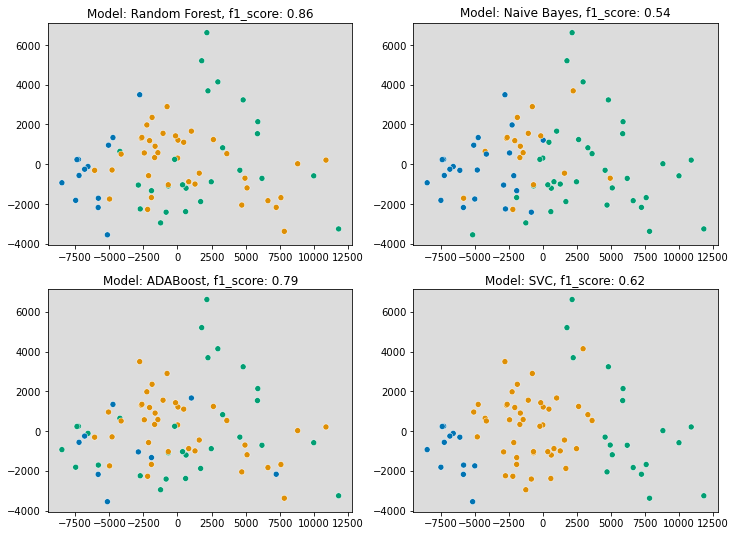

In [75]:
# Create a figure and 2x2 grid and flatten the axes.
fig1, ax1 = plt.subplots(2,2, figsize=(12, 9))
fig1.set_facecolor('white')
ax1=ax1.flatten()


# Now, for each model, test the model on the testing set and
# plot the answers by reducing the dataset using PCA.
for i, name, model in zip(range(0, len(ax1)), names, models):
    # Predict the species on the test dataset.
    ans = model.predict(final_test)

    # Perform PCA on our df and extract 2 components.
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(final_test)
    score = f1_score(y_true=final_test_ans, y_pred=ans, average='weighted')

    # Plot the 2D scatterplot and then set the title of each plot.
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    hue=ans, ax=ax1[i], palette='colorblind')
    ax1[i].set_title(f'Model: {name}, f1_score: {round(score, 2)}')
    ax1[i].get_legend().remove()
    ax1[i].set_facecolor('gainsboro')
